In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
print("Libraries imported successfully.\n")

Libraries imported successfully.



In [2]:
# Load Data
df = pd.read_csv('train_data.csv')
print(f"Training data loaded with shape: {df.shape}\n")

Training data loaded with shape: (5807, 97)



In [3]:
y = df['Bankrupt?']
idx_col = df['Index'].copy()
X_raw = df.drop(columns=['Bankrupt?', 'Index'])
print(f"Features shape after dropping Index and Target: {X_raw.shape}\n")


Features shape after dropping Index and Target: (5807, 95)



In [4]:
# Gaussian Transformation 
print("Applying PowerTransformer (Yeo-Johnson) to make features Gaussian...")
pt = PowerTransformer(method='yeo-johnson')
X_gauss = pd.DataFrame(pt.fit_transform(X_raw), columns=X_raw.columns)
print("Transformation applied.\n")

Applying PowerTransformer (Yeo-Johnson) to make features Gaussian...
Transformation applied.



In [5]:
# kept = X_gauss.columns.tolist()
# # print(f"{len(kept)} features kept:\n", kept)
# stats = X_gauss.agg(['mean', 'std', 'skew', 'kurt']).T.round(3)
# # display(stats)  

From this we can see that many of these features have really high skew and kurtosis, we will filter to identify these heavy tailed features and then winsorize them. Winsorizing allows us to replace the top/bottom 1 % with the nearest percentile value, and reduce long tails without distorting middle mass. For cases where our skew is greater than 3 and the kurtosis is greater than 30 even after applying the Box-Cox normalization transform, we will apply this technique to further normalize the distribution of these heavy tailed features.

In [6]:
# Identify Heavy-Tailed Features and Winsorize
stats = X_gauss.agg(['mean', 'std', 'skew', 'kurt']).T
heavy_skew = stats.index[stats['skew'].abs() > 3]
heavy_kurt = stats.index[stats['kurt'].abs() > 30]
heavy_features = sorted(set(heavy_skew) | set(heavy_kurt))
print(f"Found {len(heavy_features)} heavy-tailed features.\n")

def winsorize_series(s, p=0.01):
    return pd.Series(st.mstats.winsorize(s, limits=[p, p]), index=s.index)

X_wins = X_gauss.copy()
for col in heavy_features:
    X_wins[col] = winsorize_series(X_wins[col])
# print("Winsorization completed.\n")


Found 49 heavy-tailed features.



In [7]:
# Remove Highly Correlated Features
def corr_filter(df, threshold=0.6):
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)

X_uncorr = corr_filter(X_wins)


In [8]:
# Drop constant column manually if present
if 'Net Income Flag' in X_uncorr.columns:
    X_uncorr.drop(columns=['Net Income Flag'], inplace=True)
print(f"Number of features after cleaning: {len(X_uncorr.columns)}\n")
selector = VarianceThreshold()
selector.fit(X_uncorr)
feature_variances = pd.Series(selector.variances_, index=X_uncorr.columns)
selected_features = feature_variances.sort_values(ascending=False).head(28).index.tolist()
X_final = X_uncorr[selected_features]

# print(f"Number of features after final selection: {len(X_final.columns)}\n")


Number of features after cleaning: 38



In [9]:
# KMeans Clustering setup
k = 4
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
labels = kmeans.fit_predict(X_final) + 1


print("Attaching cluster labels to data...")
clustered_df = X_final.copy()
clustered_df['Cluster'] = labels
clustered_df['Bankrupt?'] = y
clustered_df['Index'] = idx_col
print("KMeans clustering completed.\n")

# Table to show cluster composition
cluster_df = pd.DataFrame({
    "cluster": labels,      # labels returned by km.fit_predict
    "bankrupt": y.values    # 1 = bankrupt, 0 = healthy
})

# summary table: total firms, # bankrupt, % bankrupt per cluster
summary = (
    cluster_df
    .groupby("cluster")["bankrupt"]
    .agg(total   = "count",
         bankrupt= "sum")
    .assign(pct_bankrupt = lambda t: t["bankrupt"] / t["total"])
    .sort_index()
)

print("\nCluster composition:")
display(summary)            

Attaching cluster labels to data...
KMeans clustering completed.


Cluster composition:


,total,bankrupt,pct_bankrupt
cluster,,,
1,2200,70,0.031818
2,1060,78,0.073585
3,1361,39,0.028655
4,1186,11,0.009275


In‑sample accuracy: 1.000

Top features by Gini importance:


,importance
Fixed Assets Turnover Frequency,0.190429
Revenue per person,0.098763
Operating Expense Rate,0.085374
Research and development expense rate,0.078517
Revenue Per Share (Yuan ¥),0.063894
Operating Gross Margin,0.047514
Allocation rate per person,0.047462
Long-term fund suitability ratio (A),0.046532
Current Asset Turnover Rate,0.040945
Current Ratio,0.037730


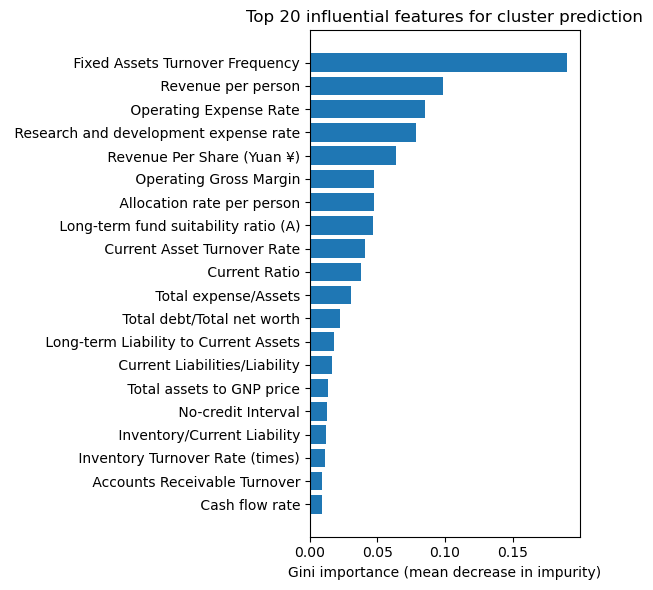

In [10]:
# now, build a classification model that predicts which cluster a company will likely belong to 

# random forest classifier 
rf = RandomForestClassifier(
        n_estimators = 500,     
        max_depth    = None,   
        random_state = 42,
     ).fit(X_uncorr, labels)

print(f"In‑sample accuracy: {rf.score(X_uncorr, labels):.3f}")

# ---------------------------------------------------------------
# 1.  GINI IMPORTANCE 
# ---------------------------------------------------------------
gini_imp = pd.Series(rf.feature_importances_,
                     index=X_uncorr.columns)\
             .sort_values(ascending=False)

# ---------------------------------------------------------------
# 2.  DISPLAY & PLOT TOP FEATURES
# ---------------------------------------------------------------
topN = 20                                   
print("\nTop features by Gini importance:")
display(gini_imp.head(topN).to_frame("importance"))

plt.figure(figsize=(6, topN*0.25+1))
plt.barh(gini_imp.head(topN)[::-1].index,
         gini_imp.head(topN)[::-1].values)
plt.xlabel("Gini importance (mean decrease in impurity)")
plt.title(f"Top {topN} influential features for cluster prediction")
plt.tight_layout(); plt.show()


In [18]:
# Filter Cluster 2 data
cluster_2_mask = (labels == 2)

X_cluster2 = X_uncorr[cluster_2_mask]
y_cluster2 = y[cluster_2_mask]
X_cluster2.columns = X_cluster2.columns.str.strip()
selected_features = [
    'Fixed Assets Turnover Frequency',
    'Revenue per person',
    'Operating Expense Rate',
    'Research and development expense rate',
    'Revenue Per Share (Yuan ¥)',
    'Operating Gross Margin',
    'Allocation rate per person',
    'Long-term fund suitability ratio (A)',
    'Current Asset Turnover Rate',
    'Current Ratio',
]

X_cluster2=X_cluster2[selected_features]


print("Cluster 2 Class Distribution:")
print(y_cluster2.value_counts(normalize=True))

Cluster 2 Class Distribution:
0    0.926415
1    0.073585
Name: Bankrupt?, dtype: float64


In [19]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Base models (non-parametric)
estimators = [
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('xgb', GradientBoostingClassifier(random_state=42)),
    ('svm', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)),
    ('knn', KNeighborsClassifier())
]

# Meta-model (logistic regression)
meta_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# SMOTE for imbalance handling (only applied to training folds via pipeline)
resampler = SMOTE(random_state=42)

# Stacking classifier with SMOTE
stacking_pipeline = ImbPipeline([
    ('smote', resampler),
    ('stack', StackingClassifier(estimators=estimators, final_estimator=meta_model, cv=cv))
])

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer

# Define accuracy scorer
accuracy_scorer = make_scorer(accuracy_score)

base_accuracy = {}
for name, model in estimators:
    # Pipeline with SMOTE for each base model
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])
    
    # Cross-validate using accuracy
    scores = cross_val_score(pipeline, X_cluster2, y_cluster2, 
                            cv=cv, scoring=accuracy_scorer, n_jobs=-1)
    base_accuracy[name] = scores.mean()

print("Base Models' Average Accuracy:")
for name, score in base_accuracy.items():
    print(f"{name}: {score:.3f}")

Base Models' Average Accuracy:
rf: 0.888
xgb: 0.853
svm: 0.769
knn: 0.814


In [21]:
from sklearn.metrics import make_scorer, recall_score

# Custom scorer to optimize recall for bankruptcies (y=1)
recall_scorer = make_scorer(recall_score, pos_label=1)

# RandomizedSearchCV for efficient tuning

param_grid = {
    'stack__rf__max_depth': [None, 20, 30],  # Deeper trees
    'stack__rf__min_samples_leaf': [1, 2],  # More flexible
    'stack__xgb__n_estimators': [200, 300],  # More trees
    'stack__xgb__learning_rate': [0.05, 0.1],
    'stack__svm__C': [10, 100],  # Higher regularization
    'stack__knn__n_neighbors': [3, 5]  # Fewer neighbors
}

search = RandomizedSearchCV(
    stacking_pipeline,
    param_grid,
    n_iter=50,
    scoring='accuracy',
    cv=3,  # Reduced CV folds for more overfitting
    n_jobs=-1
)


search.fit(X_cluster2, y_cluster2)
best_model = search.best_estimator_
print(f"Best Accuracy (Bankruptcy): {search.best_score_:.3f}")
print("Best Params:", search.best_params_)

Best Accuracy (Bankruptcy): 0.924
Best Params: {'stack__xgb__n_estimators': 300, 'stack__xgb__learning_rate': 0.1, 'stack__svm__C': 100, 'stack__rf__min_samples_leaf': 1, 'stack__rf__max_depth': 20, 'stack__knn__n_neighbors': 3}


In [22]:
# Cross-validate the stacking model with accuracy
stacking_scores = cross_val_score(best_model, X_cluster2, y_cluster2, 
                                 cv=cv, scoring=accuracy_scorer, n_jobs=-1)

print(f"\nMeta-Model (Stacking) Average Accuracy: {stacking_scores.mean():.3f}")


Meta-Model (Stacking) Average Accuracy: 0.921



Cluster 2 Bankruptcy Model Performance:
Member Name: Shreel Patel
Subgroup: Cluster 2
Accuracy: 0.921

Confusion Matrix:
[[954  28]
 [ 56  22]]

              precision    recall  f1-score   support

     Healthy       0.94      0.97      0.96       982
    Bankrupt       0.44      0.28      0.34        78

    accuracy                           0.92      1060
   macro avg       0.69      0.63      0.65      1060
weighted avg       0.91      0.92      0.91      1060



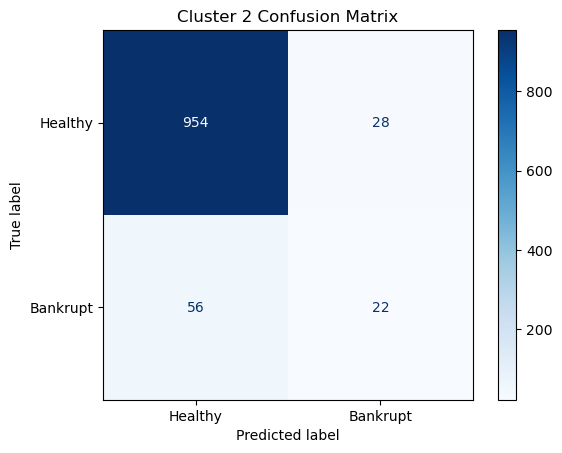


Top 10 Bankruptcy Predictors in Cluster 2:
Current Ratio                            0.181581
Operating Gross Margin                   0.167609
Current Asset Turnover Rate              0.118436
Allocation rate per person               0.096469
Long-term fund suitability ratio (A)     0.092254
Revenue Per Share (Yuan ¥)               0.079014
Revenue per person                       0.074774
Fixed Assets Turnover Frequency          0.064441
Research and development expense rate    0.062854
Operating Expense Rate                   0.062566
dtype: float64


In [23]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import (
    cross_val_predict, 
   
)


# Cross-validated predictions
y_pred = cross_val_predict(best_model, X_cluster2, y_cluster2, cv=cv, method='predict_proba')[:, 1]
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_cluster2, y_pred_binary)
conf_mat = confusion_matrix(y_cluster2, y_pred_binary)
report = classification_report(y_cluster2, y_pred_binary, target_names=['Healthy', 'Bankrupt'])

# Print formatted results
print("\nCluster 2 Bankruptcy Model Performance:")
print(f"Member Name: Shreel Patel")
print(f"Subgroup: Cluster 2")
print(f"Accuracy: {accuracy:.3f}\n")

print("Confusion Matrix:")
print(conf_mat)
print("\n" + report)

# Confusion matrix visualization
ConfusionMatrixDisplay.from_predictions(y_cluster2, y_pred_binary, 
                                      display_labels=['Healthy', 'Bankrupt'],
                                      cmap='Blues')
plt.title("Cluster 2 Confusion Matrix")
plt.show()

# Feature importances
rf_importances = best_model.named_steps['stack'].estimators_[0].feature_importances_
top_features = pd.Series(rf_importances, index=X_cluster2.columns).sort_values(ascending=False).head(10)

print("\nTop 10 Bankruptcy Predictors in Cluster 2:")
print(top_features)

In [25]:
import os
from joblib import dump
os.makedirs('artifacts', exist_ok=True)

# Save the trained model
dump(best_model, 'artifacts/cluster2_bankruptcy_model.joblib')

# Save the transformed training data (after SMOTE)

X_resampled, y_resampled = best_model.named_steps['smote'].fit_resample(X_cluster2, y_cluster2)
dump({'features': X_resampled, 'target': y_resampled}, 'artifacts/cluster2_transformed_data.joblib')

print("Model and transformed data saved in artifacts/ directory")

Model and transformed data saved in artifacts/ directory
